In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from pathlib import Path
import glob

def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [4]:
import cv2

def resize_pad(frame, desired_size):
    # function that resized an image and padding
    # to keep its aspect ratio

    old_size = frame.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    frame = cv2.resize(frame, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im

In [5]:
import mediapipe

def get_2dPts_from_img(frame, faceModule, desired_size=450, show_image = False):
    
    # Get X,Y of face
    xs = []
    ys = []
    
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        
        #resize the image
        frame = resize_pad(frame, desired_size)
        
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: # if faces detected
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height
                    # so we will get back their actual value in the image
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    
                    #append to xs ,ys
                    xs.append(relative_x)
                    ys.append(relative_y)
                    
                    if show_image:
                        #Show Image
                        cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            if show_image:
                plt.figure(figsize=(10,10))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.imshow(frame)
    return xs ,ys

In [6]:
import scipy.io as sio

def get_pyr_from_mat(mat_path):
    # Get pitch, yaw, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [7]:
from math import cos, sin

def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):
    # Function That Draws the three Axis

    yaw = -yaw

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    
    
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    

    return img

In [8]:
def pre_process_image(frame, faceModule, desired_size = 450, show_image = False):
    
    xs ,ys = get_2dPts_from_img(frame, faceModule, desired_size = 450, show_image = False)
    xs = np.array(xs)
    ys = np.array(ys)
    x_nose = xs[1]
    y_nose = ys[1]
    
    # making points with respect to poiint 1 
    xs = xs - xs[1]
    ys = ys - ys[1]
    
    # normalizing between two points [0,1]
    x_diff = xs[1] - xs[0]
    y_diff = ys[1] - ys[0]
    ratio = np.linalg.norm(np.array([x_diff,y_diff]))
    
    xs = xs / x_diff
    ys = ys / y_diff
    
    xs = np.round(xs, 2)
    ys = np.round(ys, 2)
    
    sample = np.append(
        np.array(xs), np.array(ys),
        axis=0)
    
    return sample, x_nose, y_nose

# Generating The Dataset
## Features and Labels

In [9]:
# # creating columns names
# x_column_names = ['x'+str(i) for i in range(1, 469)]
# y_column_names = ['y'+str(i) for i in range(1, 469)]
# pyr_column_names = ['pitch', 'yaw', 'roll']

# # creating empty dataframe
# df = pd.DataFrame(columns=[x_column_names + y_column_names + pyr_column_names])

# # paths to images
# img_list = get_list_from_filenames("AFLW2000/*.jpg")
# img_list = [os.path.join('AFLW2000/', file+'.jpg') for file in img_list]

# # paths to matlab files
# mat_list = get_list_from_filenames("AFLW2000/*.mat")
# mat_list = [os.path.join('AFLW2000/', file+'.mat') for file in mat_list]


# faceModule = mediapipe.solutions.face_mesh

# for index, image in enumerate(img_list):
    
#     # some images Generate errors 
#     try:
#         frame = cv2.imread(image)
#         sample, tdx, tdy = pre_process_image(frame, faceModule, desired_size = 450, show_image = False)
#         pyr = get_pyr_from_mat(mat_list[index])

#         df = df.append(
#         pd.DataFrame(
#             np.append(
#                 sample, pyr,
#                 axis=0
#             ).reshape(1,-1),
#             columns=df.columns),
#             ignore_index=True)   
#     except:
#         continue
    


# Saving The Dataframe

In [10]:
# df.to_csv('processed_data.csv', index= False)
# test_df = pd.read_csv('processed_data.csv')
# test_df.head(2)

# 3la rawa2a b2a

In [11]:
df = pd.read_csv('processed_data.csv')

#### Dropping rows that generates Erros 

In [12]:
df = df.drop(df[((df > 50000000) == True).T.any()].index)

# Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

x = df.drop(['pitch', 'yaw', 'roll'], axis=1)

pitch = df['pitch']
yaw = df['yaw']
roll = df['roll']

pitch_X_train, pitch_X_test, pitch_y_train, pitch_y_test = train_test_split(x, pitch, test_size=0.2,
                                                                    random_state=42)

yaw_X_train, yaw_X_test, yaw_y_train, yaw_y_test = train_test_split(x, yaw, test_size=0.2,
                                                                    random_state=42)

roll_X_train, roll_X_test, roll_y_train, roll_y_test = train_test_split(x, roll, test_size=0.2,
                                                                    random_state=42)

In [14]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y462,y463,y464,y465,y466,y467,y468,pitch,yaw,roll
0,-1.0,0.0,0.00,-2.50,0.00,1.00,3.00,-28.50,4.00,4.50,...,-0.09,-0.14,3.14,3.00,2.82,3.41,3.59,-0.399231,0.018227,0.085676
1,-1.0,-0.0,-1.27,-0.82,-0.00,-0.45,-1.91,-1.91,-2.36,-2.27,...,-0.18,-0.27,1.73,1.64,1.59,1.86,2.00,0.470065,1.189533,0.300959
2,-1.0,0.0,-1.00,-5.00,0.00,0.00,-2.00,-33.00,-3.00,-3.00,...,-0.10,-0.10,2.60,2.50,2.40,2.90,3.00,-0.184650,0.881137,-0.236852
3,-1.0,-0.0,-0.60,0.80,0.27,0.40,0.53,3.27,1.00,1.27,...,0.06,0.06,3.83,3.61,3.39,4.94,5.22,-0.175379,0.299208,-0.373374
4,-1.0,-0.0,-0.38,1.38,0.25,0.50,1.00,7.50,1.38,1.62,...,-0.07,-0.14,1.93,1.83,1.76,2.38,2.45,-0.026812,0.011965,-0.220662


# Standard Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

pitch_scaler = StandardScaler()
yaw_scaler = StandardScaler()
roll_scaler = StandardScaler()


pitch_xtrain_scaled = pitch_scaler.fit_transform(pitch_X_train)
pitch_xtest_scaled = pitch_scaler.transform(pitch_X_test)

yaw_xtrain_scaled = yaw_scaler.fit_transform(yaw_X_train)
yaw_xtest_scaled = yaw_scaler.transform(yaw_X_test)

roll_xtrain_scaled = roll_scaler.fit_transform(roll_X_train)
roll_xtest_scaled = roll_scaler.transform(roll_X_test)

# Model Training

In [16]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


from sklearn.metrics import mean_squared_error as MSE

In [17]:
rf_model = RandomForestRegressor(n_estimators=20,
                                       criterion='squared_error',
                                       max_depth=8)
svr_model = SVR(degree=3)
ml_model = MLPRegressor()
gbr_model = GBR()
xg_model =XGBRegressor()

models = [
    ('rf_model', rf_model),
    ('ml_model',ml_model),
    ('gbr_model',gbr_model),
    ('xg_model',xg_model)
]


## Pitch Predictor

In [32]:
pitch_predictor = RandomForestRegressor(n_estimators=20,
                                       criterion='squared_error',
                                       max_depth=8)

# pitch_predictor = VotingRegressor(estimators=models)
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)

RandomForestRegressor(max_depth=8, n_estimators=20)

In [33]:
print('Training Scores')

#print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

#print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
RMSE : 0.23221116674406622

Testing Scores
RMSE : 0.549175482899408


## Yaw Predictor


In [20]:
yaw_predictor = SVR(degree=2)

# yaw_predictor = VotingRegressor(estimators=models)
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

SVR(degree=2)

In [21]:
print('Training Scores')

#print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

#print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
RMSE : 0.24622748518335588

Testing Scores
RMSE : 0.20340628474344125


## Roll Predictor

In [39]:
roll_predictor = RandomForestRegressor(n_estimators=20,
                                       criterion='squared_error',
                                       max_depth=8)

# roll_predictor = VotingRegressor(estimators=models)
roll_predictor.fit(roll_xtrain_scaled, roll_y_train, )

RandomForestRegressor(max_depth=8, n_estimators=20)

In [40]:
print('Training Scores')

#print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

#print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
MSE : 0.25009531344004293

Testing Scores
MSE : 0.496850235239388


## Testing Models on a photo

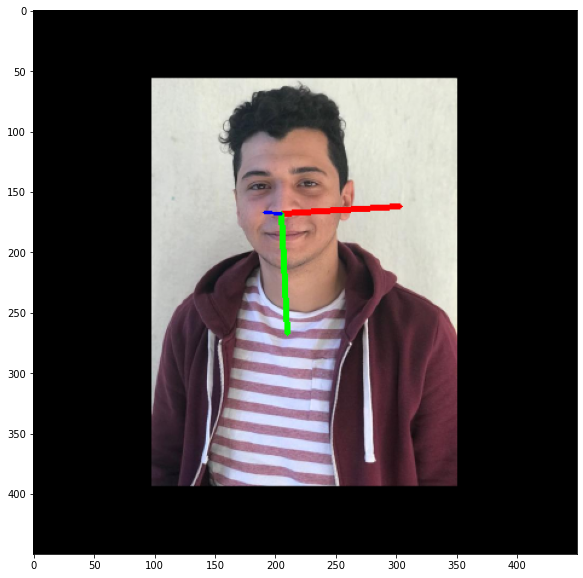

In [41]:
image_path="photo.jpeg"
faceModule = mediapipe.solutions.face_mesh

frame = cv2.imread(image_path)

features, tdx, tdy = pre_process_image(frame, faceModule, desired_size=450, show_image=False)
features = features.reshape(1,-1)

feature_pitch_scaled = pitch_scaler.transform(features)
feature_yaw_scaled = yaw_scaler.transform(features)
feature_roll_scaled = roll_scaler.transform(features)

pitch_prediction = pitch_predictor.predict(feature_pitch_scaled)
yaw_prediction = yaw_predictor.predict(feature_yaw_scaled)
roll_prediction = roll_predictor.predict(feature_roll_scaled)


im = cv2.imread(image_path)
frame = resize_pad(im, 450)
frame = draw_axis(frame, pitch_prediction,yaw_prediction, roll_prediction, tdx, tdy)

plt.figure(figsize=(10,10));

cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(cv2_frame);


### Predict Frame Funcion

In [25]:
def predict_draw_pyr(frame, faceModule, pitches, yaws, rolls, desired_size=450, show_image=False):

    features, tdx, tdy = pre_process_image(frame, faceModule, desired_size, show_image=False)
    features = features.reshape(1,-1)

    feature_pitch_scaled = pitch_scaler.transform(features)
    feature_yaw_scaled = yaw_scaler.transform(features)
    feature_roll_scaled = roll_scaler.transform(features)

    pitch_prediction = pitch_predictor.predict(feature_pitch_scaled)
    yaw_prediction = yaw_predictor.predict(feature_yaw_scaled)
    roll_prediction = roll_predictor.predict(feature_roll_scaled)
    
    if len(pitches) < 5:
        
        pitches.append(pitch_prediction)
        yaws.append(yaw_prediction)
        rolls.append(roll_prediction)
        
    else :
        pitches.pop(0)
        pitches.append(pitch_prediction)
        yaws.pop(0)
        yaws.append(yaw_prediction)
        rolls.pop(0)
        rolls.append(roll_prediction)
        
    avg_pitch = np.mean(np.array(pitches))
    avg_yaw = np.mean(np.array(yaws))
    avg_roll = np.mean(np.array(rolls))

    frame = resize_pad(frame, 450)
    frame = draw_axis(frame, avg_pitch, avg_yaw, avg_roll, tdx, tdy)
    
    return frame

# Testing on my face

In [31]:
#svideo_path = "C:/Users/DELL/AppData/Roaming/SPB_Data/[ITI]/Machine Learning 1/HeadPose Estimatio/test.mp4"
video_path = 'output.avi'
outname = 'final.avi'

faceModule = mediapipe.solutions.face_mesh

pitches, yaws, rolls = [], [], []

cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(outname, fourcc, 20.0, (450, 450))

# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))
# out = cv2.VideoWriter(outname,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (450,450))


while cap.isOpened():
    ret, cv_frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    try:
        last_frame = predict_draw_pyr(cv_frame, faceModule, pitches, yaws, rolls)   
        out.write(last_frame)
        cv2.imshow('yalla bean-a', last_frame)
        cv2.waitKey(1)
        
    except:
        continue
        
    finally:
        pass

cap.release()
out.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


In [30]:
# Python program to illustrate
# saving an operated video

# organize imports
import numpy as np
import cv2

# This will return video from the first webcam on your computer.
cap = cv2.VideoCapture(0)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 30.0, (640, 480))

# loop runs if capturing has been initialized.
while(True):
    # reads frames from a camera
    # ret checks return at each frame
    ret, frame = cap.read()
    
    # output the frame
    out.write(frame)

    # The original input frame is shown in the window
    cv2.imshow('Original', frame)

    # Wait for 'a' key to stop the program
    if cv2.waitKey(1) & 0xFF == ord('a'):
        break

# Close the window / Release webcam
cap.release()

# After we release our webcam, we also release the output
out.release()

# De-allocate any associated memory usage
cv2.destroyAllWindows()
